# MRIO Workshop

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [23]:
var_list = ['Z', 'V', 'Y', 'F_NRG', 'F_NRG_hh', 'F_GHG', 'F_GHG_hh']
Z, V, Y, F_NRG, F_NRG_hh, F_GHG, F_GHG_hh, year_list = [], [], [], [], [], [], [], []

for var in var_list:
    for year in range(1995, 2010):
        if year not in year_list:
            year_list.append(year)
        if var.split('_')[0] == 'F' and var.split('_')[-1] != 'hh':
            my_col = 0
        else:
             my_col = [0, 1]
        if var.split('_')[-1] == 'hh':
            my_header = 0
        else:
            my_header = [0, 1]
            
        df = pd.read_csv('Data/clean_data/' + var + '_' + str(year) + '.csv', header=my_header, index_col=my_col).dropna(how='all', axis=0)
        eval(var).append(df)

# 5. Calculating energy and emissions consumption-based accounts

For reference, use:  
http://www.see.leeds.ac.uk/teaching-resources/exercise-pages/l4-input-output-tutorial-201617/  
http://mathesaurus.sourceforge.net/matlab-numpy.html 

### 5.1. The UK's production and conumption based GHG emissions from 1995-2009

In [13]:
UK_consumption = []
UK_production = []
for i in range(len(year_list)):
    # territorial emissions
    UK_prod = float(F_GHG[i]['GBR'].sum(axis=1)) + float(F_GHG_hh[i]['GBR'])
    UK_production.append(UK_prod)

    # consumption based emissions
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_GHGx = np.array(F_GHG[i]) / (x.reshape(1, 1435))
    
    #Y_t = np.matrix.transpose(np.array(Y[i]))
    Y_UK = np.array(Y[i].swaplevel(axis=1)[['GBR']]).sum(axis=1).reshape(1435, 1)

    temp = np.matmul(F_GHGx, L)
    temp = np.matmul(temp, Y_UK)
    UK_cons = temp + float(F_GHG_hh[i]['GBR'])
    UK_consumption.append(UK_cons[0][0])

In [14]:
UK_co2e = pd.DataFrame()
UK_co2e['Consumption'] = UK_consumption
UK_co2e['Production'] = UK_production
UK_co2e['Year'] = year_list

Text(0.5,1,'UK')

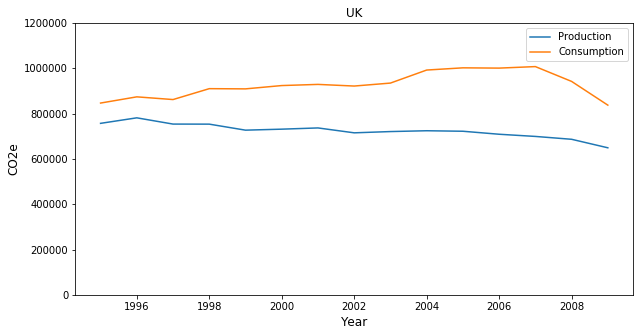

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_co2e.plot(ax=ax, x='Year', y='Production')
UK_co2e.plot(ax=ax, x='Year', y='Consumption')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('CO2e', fontsize=12)
ax.set_ylim([0,1200000])
ax.set_title('UK')

### 5.2. The UK's production and conumption based GHG emissions from 1995-2009

In [55]:
BRIC_countries = ['BRA', 'RUS', 'IND', 'CHN']
country_list = F_NRG_hh[0].columns.tolist()

BRIC_consumption = []
BRIC_production = []
for i in range(len(year_list)):
    # territorial emissions
    BRIC_prod = float(F_NRG[i][BRIC_countries].sum(axis=1)) + float(F_NRG_hh[i][BRIC_countries].sum(axis=1))
    global_prod = float(F_NRG[i].sum(axis=1)) + float(F_NRG_hh[i].sum(axis=1))
    BRIC_production.append(BRIC_prod/global_prod * 100)

    # consumption based emissions
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_NRGx = np.array(F_NRG[i]) / (x.reshape(1, 1435))
    
    temp_1 = np.matmul(F_NRGx, L)
    
    BRIC_cons = 0
    global_cons = 0
    for c in country_list:
        Y_temp = np.array(Y[i].rename(columns={'ROM':'ROU', 'RoW':'ROW'}).swaplevel(axis=1)[[c]]).sum(axis=1).reshape(1435, 1)
        temp_2 = np.matmul(temp_1, Y_temp)
        cons = temp_2 + float(F_NRG_hh[i][[c]].sum(axis=1))
        global_cons += cons[0][0]
        if c in BRIC_countries:
            BRIC_cons += cons[0][0]
        
    BRIC_consumption.append(BRIC_cons/global_cons * 100)

In [56]:
BRIC_energy = pd.DataFrame()
BRIC_energy['Consumption'] = BRIC_consumption
BRIC_energy['Production'] = BRIC_production
BRIC_energy['Year'] = year_list

Text(0.5,1,'BRIC Countries')

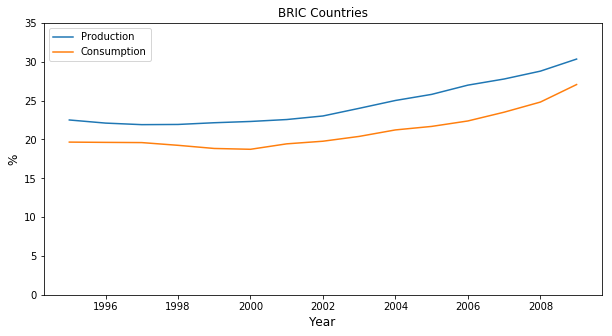

In [59]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

BRIC_energy.plot(ax=ax, x='Year', y='Production')
BRIC_energy.plot(ax=ax, x='Year', y='Consumption')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,35])
ax.set_title('BRIC Countries')

### 5.3. What proportion of the UK’s GHG footprint is sourced from BRIC nations?

In [161]:
BRIC_countries = ['BRA', 'RUS', 'IND', 'CHN']
UK_BRIC = []
sectors = 35

for i in range(len(year_list)):
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_GHGx = np.array(F_GHG[i]) / (x.reshape(1, 1435))
    
    Y_UK = np.array(Y[i].swaplevel(axis=1)[['GBR']]).sum(axis=1).reshape(1435, 1)

    temp = np.matmul(np.diag(F_GHGx[0]), L)
    temp = np.matmul(temp, np.diag(Y_UK.reshape(1, 1435)[0]))
    temp = pd.DataFrame(temp, index=Z[0].index, columns=Z[0].columns) # change back into df to more easily extract the countries
    
    BRIC_value = 0
    for c in BRIC_countries:
        temp_1 = temp.T[c].sum().sum()
        BRIC_value += temp_1
    
    UK_BRIC.append(BRIC_value/UK_consumption[i] * 100)   

In [162]:
UK_BRIC_ghg = pd.DataFrame()
UK_BRIC_ghg['BRIC_prop'] = UK_BRIC
UK_BRIC_ghg['Year'] = year_list

Text(0.5,1,'UK GHG - BRIC Proportion')

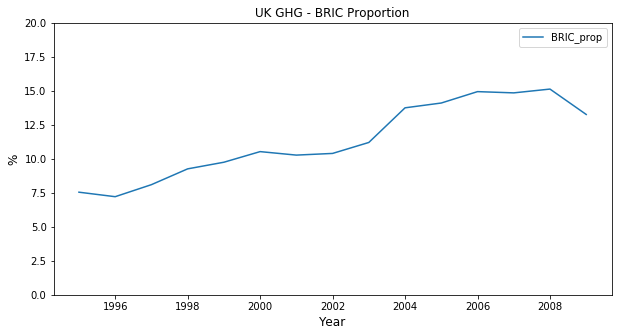

In [163]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_BRIC_ghg.plot(ax=ax, x='Year', y='BRIC_prop')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,20])
ax.set_title('UK GHG - BRIC Proportion')

### 5.4. What proportion of UK’s GHG footprint can be shown to originate from the agricultural industry?

In [180]:
UK_agriculture = []

for i in range(len(year_list)):
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_GHGx = np.array(F_GHG[i]) / (x.reshape(1, 1435))
    
    Y_UK = np.array(Y[i].swaplevel(axis=1)[['GBR']]).sum(axis=1).reshape(1435, 1)

    temp = np.matmul(np.diag(F_GHGx[0]), L)
    temp = np.matmul(temp, np.diag(Y_UK.reshape(1, 1435)[0]))
    temp = pd.DataFrame(temp, index=Z[0].index, columns=Z[0].columns) # change back into df to more easily extract the countries
    
    agri_value = temp.T.swaplevel(axis=1)['c1'].sum().sum()
    
    UK_agriculture.append(agri_value/UK_consumption[i] * 100)   

In [181]:
UK_agri_ghg = pd.DataFrame()
UK_agri_ghg['agri_prop'] = UK_agriculture
UK_agri_ghg['Year'] = year_list

Text(0.5,1,'UK GHG - Agriculture Proportion')

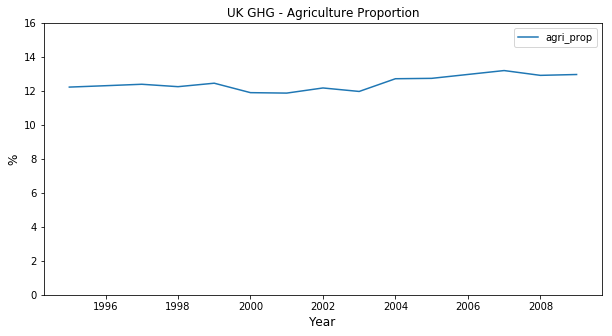

In [182]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_agri_ghg.plot(ax=ax, x='Year', y='agri_prop')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,16])
ax.set_title('UK GHG - Agriculture Proportion')

In [183]:
# above answer is off by about 1% for each year .. 

### 6.1. Make Y_G8 a ‘1 x 1435’ vector showing the final demand of the G8 nations and use this to find the total energy footprint of G8 nations 
--> not using aggregate matrices, because can use panda index

In [203]:
G8 = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']
country = ['AUS','AUT','BEL','BGR','BRA','CAN','CHN','CYP','CZE','DEU','DNK','ESP','EST','FIN','FRA','GBR','GRC','HUN','IDN','IND','IRL','ITA','JPN','KOR',
           'LTU','LUX','LVA','MEX','MLT','NLD','POL','PRT','ROU','RUS','SVK','SVN','SWE','TUR','TWN','USA','ROW']

In [234]:
regions = len(country)
final_demand = 5
G8_Y_agg = np.zeros((regions*final_demand, 1))
G8_lookup = np.zeros((regions,1))

for i in range(len(country)):
    if country[i] in G8:
        G8_lookup[i] = 1
        
for i in range(len(G8_lookup)):
    j = i+1 # because indexing starts at 0 in python
    if G8_lookup[i] == 1:
        G8_Y_agg[(j*final_demand)-final_demand:j*final_demand] = np.ones((final_demand,1))

In [257]:
G8_energy_cons = []

for i in range(len(year_list)):
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_NRGx = np.array(F_NRG[i]) / (x.reshape(1, 1435))
    
    Y_G8 = np.matmul(np.array(Y[i]),  G8_Y_agg)
    
    temp = np.matmul(F_GHGx, L)
    temp = np.matmul(temp, Y_G8)
    
    temp_1 = np.matmul(np.array(F_NRG_hh[i]), G8_lookup)
    
    G8_cons = temp[0][0] + temp_1[0][0]
    
    G8_energy_cons.append(G8_cons)

In [277]:
G8_Y_agg

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [276]:
Y_G8.shape

(1435, 1)

In [259]:
G8_cons_nrg = pd.DataFrame()
G8_cons_nrg['nrg_cons'] = G8_energy_cons
G8_cons_nrg['Year'] = year_list

In [263]:
G8_energy_cons

[2927859849.1245613,
 3310628697.5205264,
 3767254001.1166553,
 2827097782.398698,
 6490756210.128167,
 7338090607.734676,
 11549322520.481619,
 6558436589.909387,
 11936172126.709026,
 10850202107.608538,
 43247749.66732584,
 43058148.422035344,
 43503175.136090204,
 1411393275.2775035,
 42365470.07185404]

Text(0.5,1,'G8')

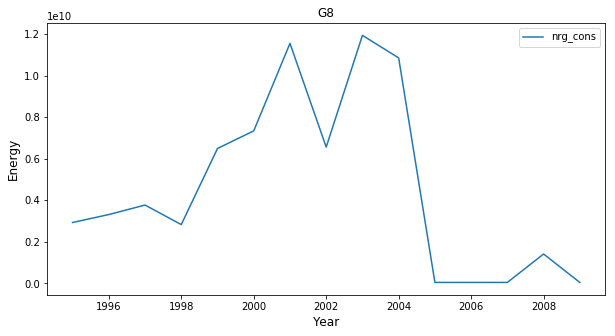

In [262]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

G8_cons_nrg.plot(ax=ax, x='Year', y='nrg_cons')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Energy', fontsize=12)
#ax.set_ylim([50000000, 400000000])
ax.set_title('G8')

In [ ]:

for year = 1995:2009
    x = sum(Z(:,:,year-1994),2)+sum(Y(:,:,year-1994),2);
    x(x==0) = 0.000000001;
    A = Z(:,:,year-1994)./repmat(x',regions*sectors,1);
    L = inv(eye(regions*sectors)-A);  
    F_NRGx = F_NRG(:,:,year-1994)./x';
    Y_G8 = Y(:,:,year-1994)*G8_Y_agg;
    G8consNRG(:,year-1994) = F_NRGx*L*Y_G8 +F_NRG_hh(:,:,year-1994)*G8lookup;
end


In [214]:
np.ones((3,5))

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])